<a href="https://colab.research.google.com/github/igorlauxen/local_grape_health/blob/main/Enhanced_Plant_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Para conectar kaggle e google driver seguir o tutorial do [Medium: How to fetch kaggle datasets into google colab](https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851a)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [ ]:
!ls /content/gdrive/MyDrive/kaggle

#changing the working directory
%cd /content/gdrive/MyDrive/kaggle
#Check the present working directory using pwd command

!ls

ignore_folder  kaggle.json  label_transform.pkl  plantvillage  PlantVillage
/content/gdrive/MyDrive/kaggle
ignore_folder  kaggle.json  label_transform.pkl  plantvillage  PlantVillage


In [ ]:
# só execute comando abaixo caso no seu google drie não tenha sido baixado as plantas ainda
#!kaggle datasets download -d emmarex/plantdisease

100% 656M/658M [00:22<00:00, 36.3MB/s]
100% 658M/658M [00:22<00:00, 30.2MB/s]


In [ ]:
# mesmo que passo anterior, caso há tenha sido executado uma vez, nao precisa ocorrer de novo
#unzipping the zip files and deleting the zip files
#!unzip \*.zip  && rm *.zip

Esse notebook baseia sua implementação em [Plant Disease Detection using Keras](https://www.kaggle.com/emmarex/plant-disease-detection-using-keras/data)

Dataset utilizado é [Plant Village Disease](https://www.kaggle.com/emmarex/plantdisease)

In [ ]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
#from keras.layers.normalization import BatchNormalization
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
# from keras.optimizers import Adam precisa importar depois como keras.optimizers.Adam segundo https://keras.io/api/optimizers/
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
# NOTA: essa pasta pode variar de location depdendo de onde der a *cd* anteriormente
directory_root = 'plantvillage/'
width=256
height=256
# depth 3 significa considerar RGB
depth=3

In [ ]:
!pwd

/content/gdrive/MyDrive/kaggle


In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
# o processamento abaixo levar alguns minutos (~15)
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        print(f"[INFO] The plant folder is {plant_folder} ...")
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        print(f"[INFO] The plant disease folder list is {plant_disease_folder_list} ...")
        for disease_folder in plant_disease_folder_list :
            print(f"[INFO] The disease folder is {disease_folder} ...")
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)
            if disease_folder == "Tomato_Spider_mites_Two_spotted_spider_mite":
                print(f"[INFO] Folder {disease_folder} has been ignored ...")
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] The plant folder is PlantVillage ...
[INFO] The plant disease folder list is ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy'] ...
[INFO] The disease folder is Pepper__bell___Bacterial_spot ...
[INFO] The disease folder is Pepper__bell___healthy ...
[INFO] The disease folder is Potato___Early_blight ...
[INFO] The disease folder is Potato___Late_blight ...
[INFO] The disease folder is Potato___healthy ...
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Processing Pepper__bell___healthy ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Potato___healthy ...
[INFO] Image loading completed


In [ ]:
image_size = len(image_list)
print("image size is ", image_size)

image size is  952


In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

# Nota sobre os dados

Afim de aumentar a velocidade de processamento, foi reduzido o dataset para considerar somente batatas e pimentas.

Considerando os dados de tomate, o modelo levava mais de 4hrs para treinar, dificuldade testes e validações do grupo

In [ ]:
print(label_binarizer.classes_)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy']


In [ ]:
np_image_list = np.array(image_list, dtype=np.float32) / 225.0

In [ ]:
print(np_image_list)

In [ ]:
print("[INFO] Spliting data to train, test")
# o que faz train_test_split?
# r: ele dividi o dataset em dados de treino e validação. 
# O parametro test_size é de 0 a 1 e é o que define o percentual que vai para validação
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [ ]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

# Nota

Modelo abaixo não é executado pois somente foi usado como referencia de código.

In [ ]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
# tf.keras.layers.Conv2D(filters (32),kernel_size(3,3)
# padding pode ser same ou valid. valid: "valid" means no padding
#   same: results in padding with zeros evenly to the left/right or up/down of the input such that output has the same height/width dimension as the input.
# inputShape=(256,256,3): alta resolução com cores
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
# What is activation function? an activation function is needed that looks and acts like a linear function, 
# but is, in fact, a nonlinear function allowing complex relationships in the data to be learned.
# What is Relu? Rectified Linear Unit (ReLU)
# linear function that will output the input directly if it is positive, otherwise, it will output zero.
model.add(Activation("relu"))
# Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.
# The axis that should be normalized (typically the features axis). 
# For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 activation_13 (Activation)  (None, 256, 256, 32)      0         
                                                                 
 batch_normalization_12 (Bat  (None, 256, 256, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 85, 85, 32)       0         
 g2D)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 85, 85, 32)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 85, 85, 64)       

In [ ]:
from tensorflow import keras

# from keras.optimizers import a
opt = keras.optimizers.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# cada epoch demora 10 minutos, processo abaixo demora MUITO
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

In [ ]:
# save the model to disk
print("[INFO] Saving model...")
pickle.dump(model,open('cnn_model.pkl', 'wb'))

In [ ]:
tcc_model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
tcc_model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
tcc_model.add(Activation("relu"))
tcc_model.add(BatchNormalization(axis=chanDim))
tcc_model.add(MaxPooling2D(pool_size=(3, 3)))
tcc_model.add(Conv2D(64, (3, 3), padding="same"))
tcc_model.add(Activation("relu"))
tcc_model.add(BatchNormalization(axis=chanDim))
tcc_model.add(MaxPooling2D(pool_size=(2, 2)))
tcc_model.add(Conv2D(128, (3, 3), padding="same"))
tcc_model.add(Activation("relu"))
tcc_model.add(BatchNormalization(axis=chanDim))
tcc_model.add(MaxPooling2D(pool_size=(2, 2)))
tcc_model.add(Dropout(0.1))
tcc_model.add(Flatten())
tcc_model.add(Dense(1024))
tcc_model.add(Activation("relu"))
tcc_model.add(BatchNormalization())
tcc_model.add(Dropout(0.1))
tcc_model.add(Dense(n_classes))
tcc_model.add(Activation("softmax"))

In [ ]:
from tensorflow import keras

# from keras.optimizers import a
opt = keras.optimizers.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
tcc_model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
tcc_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 activation_5 (Activation)   (None, 256, 256, 32)      0         
                                                                 
 batch_normalization_4 (Batc  (None, 256, 256, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 85, 85, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 85, 85, 64)        18496     
                                                                 
 activation_6 (Activation)   (None, 85, 85, 64)       

In [ ]:
tcc_aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [ ]:
# cada epoch demora 10 minutos, processo abaixo demora MUITO
tcc_history = tcc_model.fit_generator(
    tcc_aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=2
    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/25
23/23 - 72s - loss: 0.8144 - accuracy: 0.6063 - val_loss: 1.1930 - val_accuracy: 0.3298 - 72s/epoch - 3s/step
Epoch 2/25
23/23 - 71s - loss: 0.3956 - accuracy: 0.7558 - val_loss: 10.3713 - val_accuracy: 0.2094 - 71s/epoch - 3s/step
Epoch 3/25
23/23 - 71s - loss: 0.2772 - accuracy: 0.8326 - val_loss: 15.5085 - val_accuracy: 0.2094 - 71s/epoch - 3s/step
Epoch 4/25
23/23 - 71s - loss: 0.2107 - accuracy: 0.8683 - val_loss: 19.4250 - val_accuracy: 0.2094 - 71s/epoch - 3s/step
Epoch 5/25
23/23 - 71s - loss: 0.1557 - accuracy: 0.8944 - val_loss: 23.9797 - val_accuracy: 0.2094 - 71s/epoch - 3s/step
Epoch 6/25
23/23 - 71s - loss: 0.1475 - accuracy: 0.8971 - val_loss: 28.1945 - val_accuracy: 0.2094 - 71s/epoch - 3s/step
Epoch 7/25
23/23 - 71s - loss: 0.1249 - accuracy: 0.9081 - val_loss: 25.3534 - val_accuracy: 0.2094 - 71s/epoch - 3s/step
Epoch 8/25
23/23 - 71s - loss: 0.1262 - accuracy: 0.9053 - val_loss: 25.1761 - val_accuracy: 0.2094 - 71s/epoch - 3s/step
Epoch 9/25
23/23 - 71s - 

# Estrategia

segundo o artigo utilizado como base, eles utilizaram as seguintes métricas#

1. Camadas: 32 - 64 - 128
1. Dropout de 0.1 
1. activatio feature ReLU

## Resultados previstos antes de refactoring

Utilizando a estrutura abaixo

```
tcc_model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
tcc_model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
tcc_model.add(Activation("relu"))
tcc_model.add(BatchNormalization(axis=chanDim))
tcc_model.add(MaxPooling2D(pool_size=(3, 3)))
tcc_model.add(Conv2D(64, (3, 3), padding="same"))
tcc_model.add(Activation("relu"))
tcc_model.add(BatchNormalization(axis=chanDim))
tcc_model.add(MaxPooling2D(pool_size=(2, 2)))
tcc_model.add(Conv2D(128, (3, 3), padding="same"))
tcc_model.add(Activation("relu"))
tcc_model.add(BatchNormalization(axis=chanDim))
tcc_model.add(MaxPooling2D(pool_size=(2, 2)))
tcc_model.add(Dropout(0.1))
tcc_model.add(Flatten())
tcc_model.add(Dense(1024))
tcc_model.add(Activation("relu"))
tcc_model.add(BatchNormalization())
tcc_model.add(Dropout(0.1))
tcc_model.add(Dense(n_classes))
tcc_model.add(Activation("softmax"))
```

O modelo teve uma acurácia alta (90%), porém o val_accuracy (20.94%) baixo nos primeiros 10 ciclos de desenvolvimento, o que significa que esse dataset consegue entender os dados de treino, porém os de validação ele não conseguem interpretar.

Após a décima interação, os valores de val_acc sobem para 26%. O que indica que é o modelo esta parcialmente correto, porém precisa de mais interações pra aprendizado.

Ao final do treino, o modelo tem uma precisão de 71% com os dados de treino, um valor considerado bom pela equipe, mas que poderia apresentar melhorias.

## Referencial

Gokulnath B.V., Usha Devi G. Identifying and classifying plant disease using resilient LF-CNN. Publicado em: Elsevier B.V. 29 de março de 2021.

# Comparação

O modelo empregado por [Tairu Oluwafemi Emmanuel](https://www.kaggle.com/emmarex) em [Plant Disease Detection using Keras](https://www.kaggle.com/emmarex/plant-disease-detection-using-keras/data) apresenta uma camada similar, entretanto, com mais repetições. Por exemplo, o modelo dele adiciona 2 vezes cada camada (32, 64, 128 respectivamente).

Assumimos que ele tenha adotado esse comportamento devido a um resultado similar ao que o nosso modelo objeteve

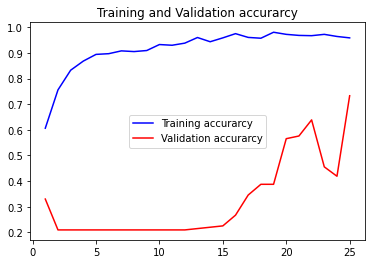

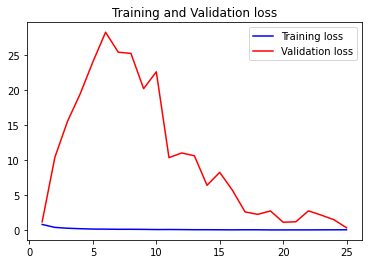

In [27]:
accuracy = tcc_history.history['accuracy']
val_acc = tcc_history.history['val_accuracy']
loss = tcc_history.history['loss']
val_loss = tcc_history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
#Train and validation accuracy
plt.plot(epochs, accuracy, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()